# Falkon model test
tutorial for the Falkon standard model

In [1]:
%matplotlib inline
from sklearn import datasets, model_selection, metrics
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import falkon
assert torch.cuda.is_available()


In [2]:
! pip freeze | grep torch

torch==1.13.1
torchaudio==0.13.1
torchvision==0.14.1


In [3]:
X, Y = datasets.fetch_california_housing(return_X_y=True)
num_train = int(X.shape[0] * 0.8)
num_test = X.shape[0] - num_train
shuffle_idx = np.arange(X.shape[0])
np.random.shuffle(shuffle_idx)
train_idx = shuffle_idx[:num_train]
test_idx = shuffle_idx[num_train:]

Xtrain, Ytrain = X[train_idx], Y[train_idx]
Xtest, Ytest = X[test_idx], Y[test_idx]

print(Xtrain.shape)
print(Xtest.shape)

Xtrain = torch.from_numpy(Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1])).to(dtype=torch.float32)
Xtest = torch.from_numpy(Xtest).to(dtype=torch.float32)
Ytrain = torch.from_numpy(Ytrain).to(dtype=torch.float32)
Ytest = torch.from_numpy(Ytest).to(dtype=torch.float32)

print(Xtrain.shape)
# print(Xtest.shape)

(16512, 8)
(4128, 8)
torch.Size([16512, 8])


In [4]:
# z-score normalization
train_mean = Xtrain.mean(0, keepdim=True)
train_std = Xtrain.std(0, keepdim=True)
Xtrain -= train_mean
Xtrain /= train_std
Xtest -= train_mean
Xtest /= train_std

In [5]:
options = falkon.FalkonOptions(keops_active="auto")

kernel = falkon.kernels.GaussianKernel(sigma=1, opt=options)
flk = falkon.Falkon(kernel=kernel, penalty=1e-5, M=5000, options=options)


In [6]:
flk.fit(Xtrain, Ytrain)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula c*Exp(Sum((a/d-b/d)**2)*-1/2) with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,1,1), d=Var(3,1,2) ... OK


Falkon(M=5000, center_selection=<falkon.center_selection.UniformSelector object at 0x7f283eb09ca0>, kernel=GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64)), options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', keops_active='auto', keops_memory_slack=0.7, chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, cg_differential_convergence=False, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True, min_cuda_pc_size_32=10000, min_cuda_pc_size_64=30000, min_cuda_iter_size_32=300000000, min_cuda_iter_size_64=900000000, never_store_kernel=False, store_kernel_d_threshold=1200, num_fmm_streams=2, memory_slack=0.9), penalty=1e-05)

In [7]:
train_pred = flk.predict(Xtrain).reshape(-1, )
test_pred = flk.predict(Xtest).reshape(-1, )

def rmse(true, pred):
    return torch.sqrt(torch.mean((true.reshape(-1, 1) - pred.reshape(-1, 1))**2))

print("Training RMSE: %.3f" % (rmse(train_pred, Ytrain)))
print("Test RMSE: %.3f" % (rmse(test_pred, Ytest)))

Training RMSE: 0.516
Test RMSE: 0.593


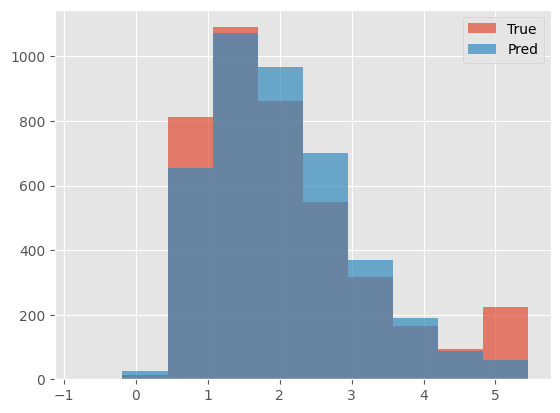

In [8]:
fig, ax = plt.subplots()
hist_range = (min(Ytest.min(), test_pred.min()).item(), max(Ytest.max(), test_pred.max()).item())
ax.hist(Ytest.numpy(), bins=10, range=hist_range, alpha=0.7, label="True")
ax.hist(test_pred.numpy(), bins=10, range=hist_range, alpha=0.7, label="Pred")
ax.legend(loc="best")

## hyperparameter tuning

In [9]:
def mclass_loss(true, pred):
    true = torch.argmax(true, dim=1)
    pred = torch.argmax(pred, dim=1)
    return torch.mean((true != pred).to(torch.float32))
mclass_scorer = metrics.make_scorer(mclass_loss, greater_is_better=False)

In [10]:
parameter_grid = {
    'kernel': [falkon.kernels.GaussianKernel(sigma=1),
               falkon.kernels.GaussianKernel(sigma=5),
               falkon.kernels.GaussianKernel(sigma=10),
               falkon.kernels.GaussianKernel(sigma=15),],
    'penalty': [1e-5, 1e-7, 1e-9],
    'M': [500, 1000, 2000],
}
estimator = falkon.Falkon(
    kernel=falkon.kernels.GaussianKernel(1), penalty=1e-3, M=1000,  # Mandatory parameters, will be overridden
    maxiter=10, options=falkon.FalkonOptions(use_cpu=False))

grid_search = model_selection.GridSearchCV(estimator, parameter_grid, scoring=mclass_scorer, cv=5)

In [11]:
%%time
grid_search.fit(Xtrain, Ytrain)
print("The best parameters are: ", grid_search.best_params_)

/home/ubuntu/miniconda3/envs/falkon-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/falkon-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 977, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/miniconda3/envs/falkon-env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/miniconda3/envs/falkon-env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/tmp/ipykernel_472361/2865778538.py", line 2, in mclass_loss
    true = torch.argmax(true, dim=1)
IndexError: Dime

The best parameters are:  {'M': 500, 'kernel': GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64)), 'penalty': 1e-05}
CPU times: user 36min 26s, sys: 19.7 s, total: 36min 46s
Wall time: 2min 17s
